## Notebook Overview: Mixed Layer Depth Comparison Across Dock Locations

This notebook conducts a horizontal comparison of mixed layer depth (MLD) values across multiple dock locations in Stagecoach Reservoir. It merges CTD cast identifiers with corresponding MLD estimates and provides visual and statistical insight into spatial mixing patterns.

### Objectives:
- **Load and Merge Datasets**: Combine cast metadata and MLD estimates using unique cast identifiers.
- **Identify Gaps**: Detect and patch missing MLD values manually when necessary.
- **Visualize Spatial Patterns**: Create comparative plots across East, Central, and West dock regions to analyze how MLD varies spatially.
- **Highlight Mixing Variability**: Evaluate whether short-term environmental or locational differences are contributing to observed MLD disparities.

The goal is to better understand how mixing differs across horizontal spatial scales in the reservoir, supporting targeted environmental monitoring and analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

✅  Merged casts with MLD: 49 rows (should be 49)

Number of casts per dock per day (goal: all 3):
dock        Dock_1  Dock_2  Dock_3
date                              
2025-05-13       2       2       2
2025-05-14       2       2       2
2025-05-15       3       4       3
2025-05-16       3       3       4
2025-05-17       3       5       3
2025-05-18       1       1       1
2025-05-19       1       1       1

Daily mean mixed‑layer depth (m):
dock          Dock_1    Dock_2  Dock_3
date                                  
2025-05-13  4.900000  5.900000     NaN
2025-05-14  1.500000  5.500000    2.00
2025-05-15  4.233333  3.600000    4.70
2025-05-16  4.733333  5.566667    5.05
2025-05-17  4.533333  1.980000    5.60
2025-05-18       NaN       NaN     NaN
2025-05-19       NaN       NaN     NaN

--- Friedman test ---
χ² = 2.000   p = 0.368

--- Pair‑wise Wilcoxon signed‑rank (Bonferroni‑adjusted) ---
Dock_1 vs Dock_2 :  n=4  W=4.000  p_raw=0.875  p_adj=1.000
Dock_1 vs Dock_3 :  n=4  W=0.000  

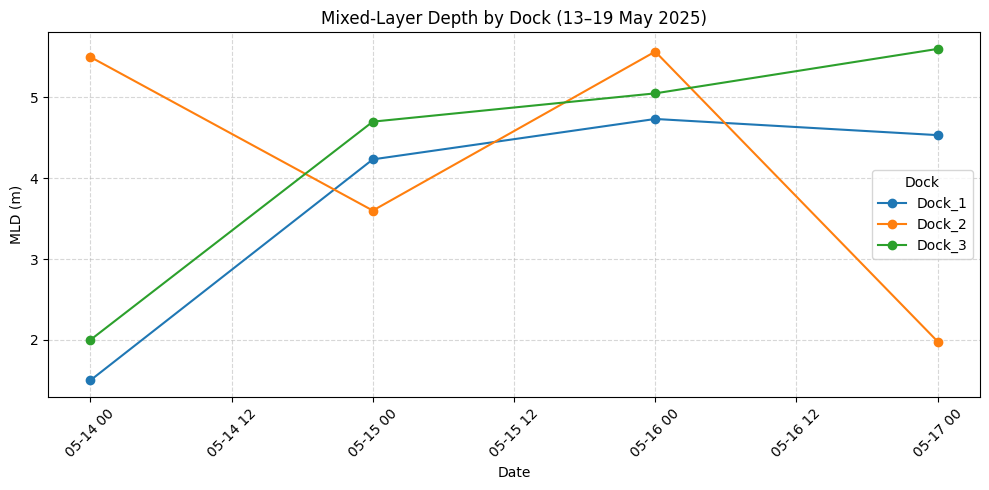

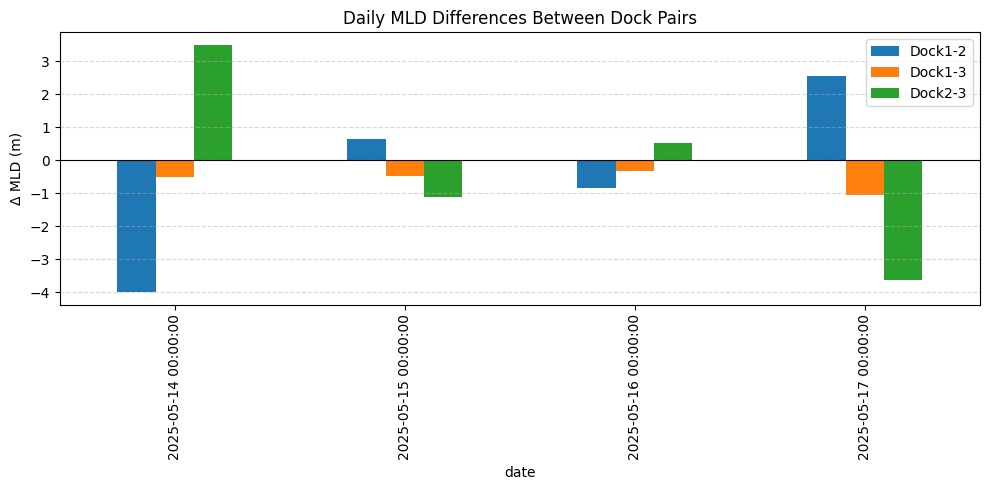

In [3]:
# load data
ids_path = "/content/drive/MyDrive/Field_Camp /dock/dock_casts_with_ids.csv"
mld_path = "/content/drive/MyDrive/Field_Camp /dock/dock_casts_with_mld.csv"

ids_df = pd.read_csv(ids_path)
mld_df = pd.read_csv(mld_path)

# Strip whitespace from Cast ID just in case
ids_df["Cast ID"] = ids_df["Cast ID"].str.strip()
mld_df["Cast ID"] = mld_df["Cast ID"].str.strip()

# BUILD A UNIQUE‑CAST TABLE FROM ids_df
uids = (ids_df.sort_values("Cast ID")
               .drop_duplicates("Cast ID")
               .reset_index(drop=True))

# Keep only the GPS + date columns we need
if "date" not in uids.columns:
    uids["date"] = pd.to_datetime(
        uids["Cast ID"].str.extract(r"_(\d{8})_")[0], format="%Y%m%d"
    )
uids = uids[["Cast ID", "Start latitude", "Start longitude", "date"]]

# TAKE ONLY CASTS THAT HAVE AN MLD
mld_unique = (mld_df[["Cast ID", "Dock Location", "MLD"]]
              .drop_duplicates("Cast ID"))

casts = (uids.merge(mld_unique, on="Cast ID", how="inner")
              .rename(columns={"Dock Location": "dock"}))

print(f"✅  Merged casts with MLD: {casts.shape[0]} rows (should be 49)")

# -----------------------------------------------------------
# 4.  VERIFY 3 x 3 CASTS PER DAY ----------------------------
cast_counts = (casts.groupby(["date", "dock"])["Cast ID"]
                     .nunique()
                     .unstack(fill_value=0)
                     .sort_index())
print("\nNumber of casts per dock per day (goal: all 3):")
print(cast_counts)

# DAILY MEAN MLD
daily_mean = (casts.groupby(["date", "dock"])["MLD"]
                     .mean()
                     .unstack())  # index=date, columns=dock

print("\nDaily mean mixed‑layer depth (m):")
print(daily_mean)

# STATISTICS
from scipy.stats import friedmanchisquare, wilcoxon

# Friedman requires complete rows
complete = daily_mean.dropna()
stat, p = friedmanchisquare(complete["Dock_1"],
                            complete["Dock_2"],
                            complete["Dock_3"])
print(f"\n--- Friedman test ---\nχ² = {stat:.3f}   p = {p:.3f}")

pairs = [("Dock_1", "Dock_2"), ("Dock_1", "Dock_3"), ("Dock_2", "Dock_3")]
print("\n--- Pair‑wise Wilcoxon signed‑rank (Bonferroni‑adjusted) ---")
for a, b in pairs:
    both = complete[[a, b]].dropna()
    stat, p_raw = wilcoxon(both[a], both[b])
    p_adj = min(p_raw * len(pairs), 1.0)
    print(f"{a} vs {b:7s}:  n={len(both):d}  W={stat:.3f}  p_raw={p_raw:.3f}  p_adj={p_adj:.3f}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for dock in ["Dock_1", "Dock_2", "Dock_3"]:
    plt.plot(complete.index, complete[dock], marker="o", label=dock)
plt.title("Mixed‑Layer Depth by Dock (13–19 May 2025)")
plt.ylabel("MLD (m)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Dock")
plt.tight_layout()
plt.show()

diffs = pd.DataFrame({
    "date": complete.index,
    "Dock1‑2": complete["Dock_1"] - complete["Dock_2"],
    "Dock1‑3": complete["Dock_1"] - complete["Dock_3"],
    "Dock2‑3": complete["Dock_2"] - complete["Dock_3"],
}).set_index("date")

diffs.plot(kind="bar", figsize=(10, 5))
plt.title("Daily MLD Differences Between Dock Pairs")
plt.ylabel("Δ MLD (m)")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [4]:
# WHICH CASTS HAVE NO MLD?
missing_mld = casts[casts["MLD"].isna()]
print(f"\nCasts lacking MLD values ({missing_mld.shape[0]} rows):")
print(missing_mld[["Cast ID", "date", "dock"]].to_string(index=False))

# QUICK HEAT‑MAP OF MLD AVAILABILITY
avail = (casts.assign(has_mld = casts["MLD"].notna())
               .pivot_table(index="date", columns="dock",
                            values="has_mld", aggfunc="sum", fill_value=0))
print("\nCast count *with* MLD by date & dock (should be 3 everywhere):")
print(avail)

# PREVIEW THE RAW ROWS FROM 18 & 19 MAY
print("\n18 May rows:")
print(casts[casts["date"]=="2025-05-18"][["Cast ID","dock","MLD"]].head())
print("\n19 May rows:")
print(casts[casts["date"]=="2025-05-19"][["Cast ID","dock","MLD"]].head())



Casts lacking MLD values (8 rows):
                      Cast ID       date   dock
CC2435009_20250513_194404.csv 2025-05-13 Dock_3
CC2435009_20250513_194520.csv 2025-05-13 Dock_3
CC2435009_20250518_183359.csv 2025-05-18 Dock_2
CC2435009_20250518_184039.csv 2025-05-18 Dock_1
CC2435009_20250518_184557.csv 2025-05-18 Dock_3
CC2435009_20250519_185748.csv 2025-05-19 Dock_2
CC2435009_20250519_190629.csv 2025-05-19 Dock_1
CC2435009_20250519_191035.csv 2025-05-19 Dock_3

Cast count *with* MLD by date & dock (should be 3 everywhere):
dock        Dock_1  Dock_2  Dock_3
date                              
2025-05-13       2       2       0
2025-05-14       2       2       2
2025-05-15       3       4       3
2025-05-16       3       3       4
2025-05-17       3       5       3
2025-05-18       0       0       0
2025-05-19       0       0       0

18 May rows:
                          Cast ID    dock  MLD
43  CC2435009_20250518_183359.csv  Dock_2  NaN
44  CC2435009_20250518_184039.csv  Dock_1  Na

In [5]:
# MANUALLY PATCH THE 8 MLD VALUES THAT WERE MISSING (Visually Picked)
mld_updates = {
    "CC2435009_20250513_194404": 5.661,
    "CC2435009_20250513_194520": 5.967,
    "CC2435009_20250518_183359": 5.353,
    "CC2435009_20250518_184039": 1.988,
    "CC2435009_20250518_184557": 7.800,
    "CC2435009_20250519_185748": 6.271,
    "CC2435009_20250519_190629": 2.600,
    "CC2435009_20250519_191035": 7.495,
}

patched = 0
for cid, depth_val in mld_updates.items():
    mask = mld_df["Cast ID"].str.contains(cid, regex=False)
    if mask.sum() == 0:
        print(f"⚠️  {cid} not found in mld_df — check spelling")
    else:
        mld_df.loc[mask, "MLD"] = depth_val
        patched += mask.sum()

print(f"✅  Updated {patched} rows in mld_df with manual MLDs\n")

# OPTIONAL: save a patched copy so you don’t need to repatch next time
patched_path = "/content/drive/MyDrive/Field_Camp /dock/dock_casts_with_mld_patched.csv"
mld_df.to_csv(patched_path, index=False)
print(f"Patched file saved to:\n  {patched_path}\n")

✅  Updated 228 rows in mld_df with manual MLDs

Patched file saved to:
  /content/drive/MyDrive/Field_Camp /dock/dock_casts_with_mld_patched.csv




=== Daily mean MLD (m) ===
dock          Dock_1    Dock_2  Dock_3
date                                  
2025-05-13  4.900000  5.900000   5.814
2025-05-14  1.500000  5.500000   2.000
2025-05-15  4.233333  3.600000   4.700
2025-05-16  4.733333  5.566667   5.050
2025-05-17  4.533333  1.980000   5.600
2025-05-18  1.988000  5.353000   7.800
2025-05-19  2.600000  6.271000   7.495

=== Pair‑wise differences (m) — threshold 0.25 m ===
             Dock1‑2   Dock1‑3   Dock2‑3
date                                    
2025-05-13 -1.000000 -0.914000  0.086000
2025-05-14 -4.000000 -0.500000  3.500000
2025-05-15  0.633333 -0.466667 -1.100000
2025-05-16 -0.833333 -0.316667  0.516667
2025-05-17  2.553333 -1.066667 -3.620000
2025-05-18 -3.365000 -5.812000 -2.447000
2025-05-19 -3.671000 -4.895000 -1.224000

=== Exceeds‑threshold table (True = |Δ| > threshold) ===
            Dock1‑2  Dock1‑3  Dock2‑3
date                                 
2025-05-13     True     True    False
2025-05-14     True     Tr

<ipython-input-6-6694be1b6cf1>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'date
2025-05-13    True
2025-05-14    True
2025-05-15    True
2025-05-16    True
2025-05-17    True
2025-05-18    True
2025-05-19    True
Name: Dock1‑2, dtype: bool' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  diffs_flag.iloc[:] = (diffs.abs() > threshold)   # True if exceeds threshold
<ipython-input-6-6694be1b6cf1>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'date
2025-05-13    True
2025-05-14    True
2025-05-15    True
2025-05-16    True
2025-05-17    True
2025-05-18    True
2025-05-19    True
Name: Dock1‑3, dtype: bool' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  diffs_flag.iloc[:] = (diffs.abs() > threshold)   # True if exceeds threshold
<ipython-input-6-6694be1b6

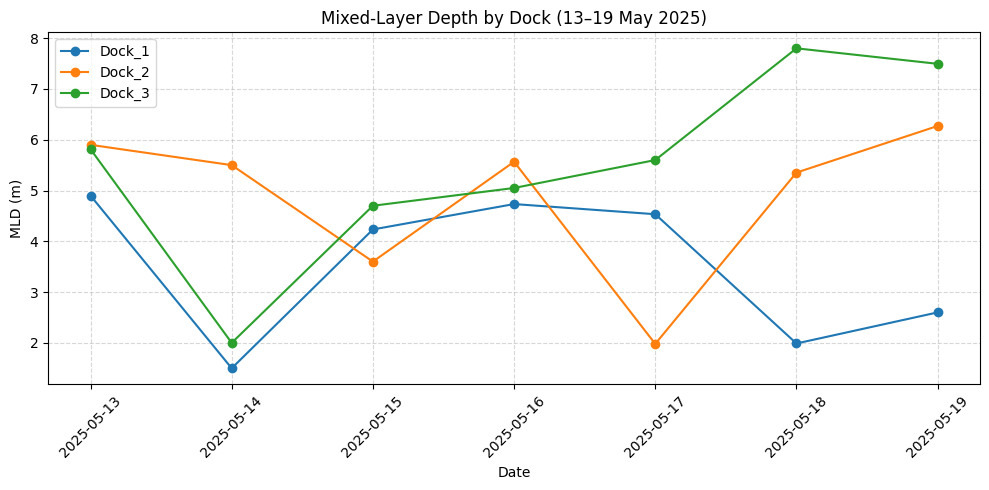

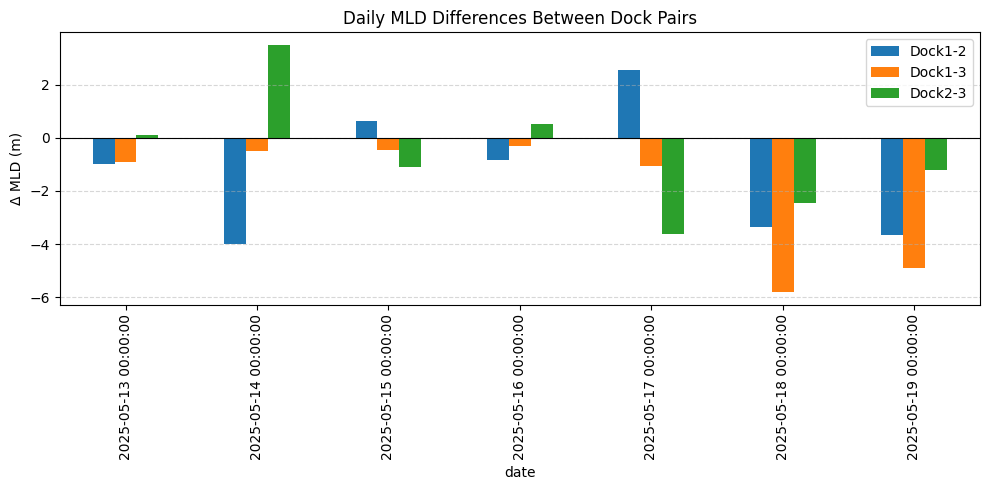

In [6]:
threshold = 0.25   # metres — mark differences exceeding this

# DAILY MEAN TABLE (13‑19 May)
mld_unique = (
    mld_df[["Cast ID", "Dock Location", "MLD"]]
          .drop_duplicates("Cast ID")
          .rename(columns={"Dock Location": "dock"})
)
casts = (
    uids.merge(mld_unique, on="Cast ID", how="inner")
)
daily_mean = (
    casts.groupby(["date", "dock"])["MLD"]
         .mean()
         .unstack()
         .reindex(columns=["Dock_1", "Dock_2", "Dock_3"])
         .sort_index()
)

print("\n=== Daily mean MLD (m) ===")
print(daily_mean)

# PAIR‑WISE DIFFERENCE TABLE
diffs = pd.DataFrame({
    "Dock1‑2": daily_mean["Dock_1"] - daily_mean["Dock_2"],
    "Dock1‑3": daily_mean["Dock_1"] - daily_mean["Dock_3"],
    "Dock2‑3": daily_mean["Dock_2"] - daily_mean["Dock_3"],
})

diffs_flag = diffs.copy()
diffs_flag.iloc[:] = (diffs.abs() > threshold)   # True if exceeds threshold

print(f"\n=== Pair‑wise differences (m) — threshold {threshold} m ===")
print(diffs)
print("\n=== Exceeds‑threshold table (True = |Δ| > threshold) ===")
print(diffs_flag)

# Plotting

plt.figure(figsize=(10, 5))
for dock in daily_mean.columns:
    plt.plot(daily_mean.index, daily_mean[dock], marker="o", label=dock)
plt.ylabel("MLD (m)")
plt.xlabel("Date")
plt.title("Mixed‑Layer Depth by Dock (13–19 May 2025)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- bar chart of pair-wise differences
diffs.plot(kind="bar", figsize=(10, 5))
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Δ MLD (m)")
plt.title("Daily MLD Differences Between Dock Pairs")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Bad casts (max depth < 6 m):
                      Cast ID       date   dock  max_depth
CC2435009_20250515_175044.csv 2025-05-15 Dock_2   3.365034
CC2435009_20250517_175943.csv 2025-05-17 Dock_2   2.289087

Within‑dock variability (good casts only):
      date   dock  count     mean      std
2025-05-13 Dock_1      2 4.900000 0.141421
2025-05-13 Dock_2      2 5.900000 0.141421
2025-05-13 Dock_3      2 5.814000 0.216375
2025-05-14 Dock_1      2 1.500000 0.707107
2025-05-14 Dock_2      2 5.500000 0.141421
2025-05-14 Dock_3      2 2.000000 0.000000
2025-05-15 Dock_1      3 4.233333 2.267892
2025-05-15 Dock_2      3 4.100000 1.743560
2025-05-15 Dock_3      3 4.700000 2.951271
2025-05-16 Dock_1      3 4.733333 1.069268
2025-05-16 Dock_2      3 5.566667 0.665833
2025-05-16 Dock_3      4 5.050000 0.129099
2025-05-17 Dock_1      3 4.533333 2.369247
2025-05-17 Dock_2      4 2.175000 2.350000
2025-05-17 Dock_3      3 5.600000 0.346410
2025-05-18 Dock_1      1 1.988000      NaN
2025-05-18 Dock_2 

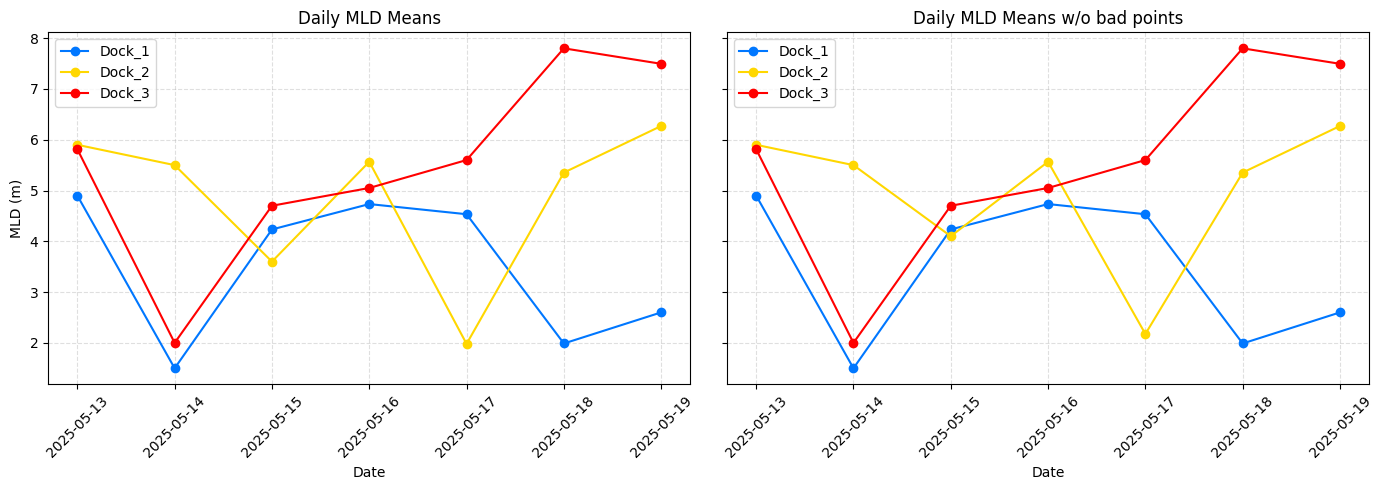

In [7]:
# compute max depth of each cast from ids_df (raw depth col)
depth_by_cast = (
    ids_df.groupby("Cast ID")["Depth (Meter)"]
          .max()
          .rename("max_depth")
)

# join to casts table
casts = casts.merge(depth_by_cast, on="Cast ID", how="left")

# flag casts whose max depth < 6 m
casts["bad_cast"] = casts["max_depth"] < 6.0

print("\nBad casts (max depth < 6 m):")
print(casts[casts["bad_cast"]][["Cast ID", "date", "dock", "max_depth"]]
      .to_string(index=False))

# std‐dev of MLD within each dock per day (after dropping bad casts)
good_casts = casts[~casts["bad_cast"]]

variability = (
    good_casts.groupby(["date", "dock"])["MLD"]
              .agg(["count", "mean", "std"])
              .reset_index()
)

print("\nWithin‑dock variability (good casts only):")
print(variability.to_string(index=False))


daily_good = (
    good_casts.groupby(["date", "dock"])["MLD"]
              .mean()
              .unstack()
              .reindex(columns=["Dock_1", "Dock_2", "Dock_3"])
)

# Avoid green and orange together (colorblind)
color_palette = {
    "Dock_1": "#0077FF",   # bright blue
    "Dock_2": "#FFD700",   # gold/yellow
    "Dock_3": "#FF0000"    # red
}

# Plotting

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- left: all casts (previous result)
for dock in daily_mean.columns:
    color = color_palette.get(dock, 'black')  # fallback color
    axs[0].plot(
        daily_mean.index,
        daily_mean[dock],
        marker="o",
        label=dock,
        color=color
    )
axs[0].set_title("Daily MLD Means")
axs[0].set_ylabel("MLD (m)")
axs[0].set_xlabel("Date")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True, linestyle='--', alpha=.4)
axs[0].legend()

# --- right: after removing bad casts
for dock in daily_good.columns:
    color = color_palette.get(dock, 'black')
    axs[1].plot(
        daily_good.index,
        daily_good[dock],
        marker="o",
        label=dock,
        color=color
    )
axs[1].set_title("Daily MLD Means w/o bad points")
axs[1].set_xlabel("Date")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True, linestyle='--', alpha=.4)
axs[1].legend()

plt.tight_layout()
plt.show()
